<h1>TikTok Analysis - Part 2</h1>
<h2><i>Event Study</i></h2>
<h3>[2.1][Create Event Study Dataframe]</h3>

In [ ]:
### Imports ###
import pandas as pd
import numpy as np
import pytz
from scipy import stats
import matplotlib.pyplot as plt

### Set necessary workspace variables ###
# Set execution type (to avoid repeating resource intensive operations)
RUN_TYPE = 0 # set to 0 to avoid file creation process
#RUN_TYPE = 1 # set to 1 to perform emotion analysis file creation process
#RUN_TYPE = 2 # set to 2 to perform topic analysis file creation process

# Define Ekman's emotions
ekman_emotions = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise']

# Timezones
eastern = pytz.timezone("US/Eastern")
european = pytz.timezone("Europe/Berlin")

In [ ]:
### Read necessary dataframes, set index, and convert timezones ###
# Prep tweets
df_tesla = pd.read_csv('../data/tiktok/tiktok_emotions.csv').dropna()
df_tesla = df_tesla.drop(columns={'combined_text', 'combined_text_cleaned'}).rename(columns={
    'total_engagement': 'engagement',
    'combined_text_anger': 'anger',
    'combined_text_fear': 'fear',
    'combined_text_joy': 'joy',
    'combined_text_sadness': 'sadness',
    'combined_text_disgust': 'disgust',
    'combined_text_surprise': 'surprise',
    'combined_text_dominant_emotion': 'video_emotion'
})
df_tesla['timestamp'] = pd.to_datetime(df_tesla['timestamp'], format='%Y-%m-%d %H:%M:%S%z', utc=True)
if df_tesla['timestamp'].dt.tz is None:
    df_tesla['timestamp'] = df_tesla['timestamp'].dt.tz_localize(eastern)
df_tesla['timestamp'] = df_tesla['timestamp'].dt.tz_convert(eastern)
df_tesla = df_tesla.set_index('timestamp').sort_index()

# Prep nyse data
df_nyse = (pd.read_csv('../data/stocks/tesla_nyse_intraday_202305_202504-1m.csv')
    .rename(columns={'Unnamed: 0': 'timestamp'})
    .drop(columns={'open', 'high', 'low', 'close', 'volume'})
)
df_nyse['timestamp'] = pd.to_datetime(df_nyse['timestamp'], format='%Y-%m-%d %H:%M:%S%z', utc=True)
if df_nyse['timestamp'].dt.tz is None:
    df_nyse['timestamp'] = df_nyse['timestamp'].dt.tz_localize(eastern)
df_nyse['timestamp'] = df_nyse['timestamp'].dt.tz_convert(eastern)
df_nyse = df_nyse.set_index('timestamp').sort_index()

# Prep xetra data
df_xetra = (pd.read_csv('../data/stocks/tesla_xetra_intraday_202305_202504-1m.csv')
    .rename(columns={'Unnamed: 0': 'timestamp'})
    .drop(columns={'open', 'high', 'low', 'close', 'volume'})
)
df_xetra['timestamp'] = pd.to_datetime(df_xetra['timestamp'], format='%Y-%m-%d %H:%M:%S%z', utc=True)
if df_xetra['timestamp'].dt.tz is None:
    df_xetra['timestamp'] = df_xetra['timestamp'].dt.tz_localize(european)
df_xetra['timestamp'] = df_xetra['timestamp'].dt.tz_convert(european)
df_xetra = df_xetra.set_index('timestamp').sort_index()

In [ ]:
### Inspect dataframe ###
print("[Tesla]")
print("Datentyp der Spalte:", df_tesla.index.dtype)
print("Tesla Columns:", df_tesla.columns)
print("Number Videos:", len(df_tesla))

### Inspect dataframe ###
print("\n[NYSE]")
print("Datentyp der Spalte:", df_nyse.index.dtype)
print("Tesla Columns:" , df_nyse.columns)

### Inspect dataframe ###
print("\n[XETRA]")
print("Datentyp der Spalte:", df_xetra.index.dtype)
print("Tesla Columns:" , df_xetra.columns)

In [ ]:
### Group tweets to events with dominant emotion ###
def compute_event_emotion(group):
    total_engagement = group['engagement'].sum()
    weighted_emo_scores = {
        emotion: (group[emotion] * group['engagement']).sum() / total_engagement
        for emotion in ekman_emotions
    }
    event_emotion = max(weighted_emo_scores, key=weighted_emo_scores.get)
    return pd.Series({
        **weighted_emo_scores,
        'event_emotion': event_emotion
    })

if not ('event_emotion' in df_tesla.columns):
    init_len = len(df_tesla)
    # 1. Filter out videos outside market hours
    df_tesla = df_tesla[
        df_tesla.index.time >= pd.to_datetime("04:00").time()
    ]
    df_tesla = df_tesla[
        df_tesla.index.time <= pd.to_datetime("18:59").time()
    ]

    # 2. Sort by time
    df_tesla.sort_index()

    # 3. Compute time difference between videos
    df_tesla['time_diff'] = df_tesla.index.diff()

    # 4. Cluster videos to events with time_diff >= 7h
    df_tesla['new_event'] = df_tesla['time_diff'] > pd.Timedelta(hours=7)

    # 5. Cumulate events in event_id
    df_tesla['event_id'] = df_tesla['new_event'].cumsum()

    # 6. Compute the dominant emotion for each event and merge back to df
    df_event_emotions = (df_tesla
        .drop(columns=['event_id'])
        .groupby(df_tesla['event_id'], group_keys=False)
        .apply(compute_event_emotion)
        .reset_index()
    )

    df_tesla = (df_tesla
        .reset_index()
        .merge(
            df_event_emotions[['event_id', 'event_emotion']],
            on='event_id',
            how='left'
        )
    )
    df_tesla = df_tesla[['timestamp', 'event_id', 'event_emotion']]

    # 7. Set event_time to time of the earliest video of the event (models from what point in time a reaction can occur)
    df_tesla['event_time'] = df_tesla.groupby('event_id')['timestamp'].transform('min')

    # 8. Filter duplicate events
    df_tesla = df_tesla.drop_duplicates(subset=['event_id']).set_index('event_time').sort_index()
    # 9. Show new length (plain events)
    new_len = len(df_tesla)
    rm_lines = init_len - new_len
    print("[Tesla]")
    print(f"[Info] Removed {rm_lines} tuples within events. New length (#videos): {new_len}")
    print("Datentyp der Spalte:", df_tesla.index.dtype)
    print("Tesla Columns:", df_tesla.columns)

In [ ]:
### Create Event Study DataFrame (with actual, expected, abnormal return and volume ###
# 1. Filter events based on overlaps of estimation and event windows
# 2. Calculate expected and abnormal returns for each event
def filter_events(df_vid: pd.DataFrame, df_fin: pd.DataFrame, fin_tz: str, vid_tz: str = 'US/Eastern', get_pre: int = 0):
    # Define necessary vars
    est = 300
    obs = 180
    gap = est + obs
    results = []

    # 1. Filter by overlaps
    valid_events = []
    last_event = None

    # Add valid events to the list
    for date in df_vid.index:
        # First event always valid
        if last_event is None:
            valid_events.append(date)
            last_event = date
        else:
            # If timeshift > gaps, keep the current event and set as new last_event
            if (date - last_event) > pd.Timedelta(minutes=gap):
                valid_events.append(date)
                last_event = date

    # Only keep valid events
    df_vid = df_vid.loc[valid_events]
    print(f"[Overlap] New df_length: {len(df_vid)}")

    # 2. Align event_time with the next available trading timestamp
    # 2.1 Convert both their respective timezone if not yet set
    if df_vid.index.tz is None:
        df_vid.index = df_vid.index.tz_localize(vid_tz)
    elif df_vid.index.tz != vid_tz:
        df_vid.index = df_vid.index.tz_convert(vid_tz)

    # 2.2 Convert all timezones to utc (+00:00)
    df_vid.index = df_vid.index.tz_convert('UTC')
    df_fin.index = df_fin.index.tz_convert('UTC')

    # 2.3 Align vid and fin times
    for i, date in enumerate(df_vid.index):
        if date not in df_fin.index:
            future_times = df_fin.index[df_fin.index > date]
            if not future_times.empty:
                df_vid.index.values[i] = pd.Timestamp(future_times[0])

    # 3. Filter events without sufficient estimation_window data
    # 4. Filter events without sufficient event_window data
    valid_events = []

    for date in df_vid.index:
        day_data = df_fin[df_fin.index.date == date.date()]
        event_index = day_data.index.get_loc(date)

        remaining = len(day_data) - event_index

        if event_index >= est:
            if remaining >= obs:
                valid_events.append(date)

    df_vid = df_vid.loc[valid_events]
    print(f"[Sum Data] New df_length = {len(df_vid)}")

    # 5. Event study variables
    for event_row in df_vid.itertuples():
        event_id = event_row.event_id
        event_emo = event_row.event_emotion
        event_time = event_row.Index

        # 5.1 Compute estimation_ and event_window
        estimation_window = df_fin.loc[
            event_time - pd.Timedelta(minutes=est) : event_time - pd.Timedelta(minutes=1)
        ]
        event_window = df_fin.loc[
            event_time - pd.Timedelta(minutes=get_pre * est): event_time + pd.Timedelta(minutes=obs - 1)
        ]

        # 5.2 Compute expected values based on estimation window
        expected_return = estimation_window['log_return'].mean()
        expected_volume = estimation_window['log_volume'].median() # robust against outliers, see Bamber (1987)
        expected_volume_z_intraday = estimation_window['log_volume_z_intraday'].median()

        for i, fin_row in enumerate(event_window.itertuples()):
            if get_pre == 1:
                i = int((fin_row.Index - event_time).total_seconds() // 60)

            # 5.3 Compute actual and abnormal values
            actual_return = fin_row.log_return
            abnormal_return = actual_return - expected_return

            actual_volume = fin_row.log_volume
            abnormal_volume = actual_volume - expected_volume

            actual_volume_z_intraday = fin_row.log_volume_z_intraday
            abnormal_volume_z_intraday = actual_volume_z_intraday - expected_volume_z_intraday

            results.append({
                'event_id': event_id,
                'event_fin_offset': i,
                'event_time': event_time,
                'fin_time': fin_row.Index,
                'event_emo': event_emo,
                'actual_return': actual_return,
                'expected_return': expected_return,
                'abnormal_return': abnormal_return,
                'actual_volume': actual_volume,
                'expected_volume': expected_volume,
                'abnormal_volume': abnormal_volume,
                'actual_volume_z_intraday': actual_volume_z_intraday,
                'expected_volume_z_intraday': expected_volume_z_intraday,
                'abnormal_volume_z_intraday': abnormal_volume_z_intraday
            })

    # 5.4 Make dataframe from results containing metrics
    df_valid_events = pd.DataFrame(results)

    return df_valid_events

In [ ]:
### Create event_study and event_study_pre_post dataframes ###
if RUN_TYPE == 0:
    df_tesla = df_tesla[['event_id', 'event_emotion']] # index = event_time
    df_nyse = df_nyse[['log_return', 'log_volume', 'log_volume_z_intraday']] # index = timestamp
    df_xetra = df_xetra[['log_return', 'log_volume', 'log_volume_z_intraday']] # index = timestamp

    for df_stock_exchange, name in zip([df_nyse, df_xetra], ['nyse', 'xetra']):
        if name == 'df_nyse':
            fin_timezone = pytz.timezone("US/Eastern")
        else:
            fin_timezone = pytz.timezone("Europe/Berlin")

        # Create dfs (for inspection of results)
        df_event_study = filter_events(df_tesla, df_stock_exchange, fin_tz=fin_timezone)
        df_event_study_pre_post = filter_events(df_tesla, df_stock_exchange, fin_tz=fin_timezone, get_pre=1)

        # Saving as file
        df_event_study.to_csv(f'../data/tiktok/tiktok_{name}_event_study.csv')
        df_event_study_pre_post.to_csv(f'../data/tiktok/tiktok_{name}_event_study_pre_post')

        # Inspection of results
        print(f"[Info][{name}] Dataframe Inspection")
        print(f"Emotions: {df_event_study['event_emo'].unique()}")
        emotion = df_event_study['event_emo'].unique()
        for emo in emotion:
            print(f"  - {emo}: {len(df_event_study[df_event_study['event_emo'] == emo].groupby('event_id'))} events")

        print(f"\n[Info][{name}] Event Study DataFrame has {len(df_event_study)} entries.")
        print(f"[Info] Event Study Pre/Post DataFrame has {len(df_event_study_pre_post)} entries.\n")
        if (df_event_study_pre_post.columns == df_event_study.columns).all():
            print("[Info] emotion_event_study(_pre_post).csv files have the following columns:")
            print(df_event_study.columns.tolist())

<h3>[2.2][Event Study on Return]</h3>
<h4><u>3.2.1 Abnormal Return</u></h4>
<p>[Intro]</p>
<p>In the following it is analysed to what extent a significant effect of a particular emotion on the change in stock return can be observed by the minute<br>
--> Is the mean abnormal return significantly greater / lower than 0 resp. does the mean abnormal return significantly differ from the expected return?</p>
<p>
    <ul>
        <li>H0: mean abnormal return = 0</li>
        <li>H1: mean abnormal return >< 0</li>
    </ul>
</p>

In [ ]:
### Read event study dataframes ###
df_event_study_nyse = pd.read_csv('../data/tiktok/tiktok_nyse_event_study.csv')
df_event_study_nyse_pre_post = pd.read_csv('../data/tiktok/tiktok_nyse_event_study_pre_post')
df_event_study_xetra = pd.read_csv('../data/tiktok/tiktok_xetra_event_study.csv')
df_event_study_xetra_pre_post = pd.read_csv('../data/tiktok/tiktok_xetra_event_study_pre_post')

In [ ]:
### Significance Testing of AR ###
# Variables
alpha = 0.05
nyse_res = pd.DataFrame()
xetra_res = pd.DataFrame()

# Functions
def stars(p):
    if p < 0.01: return '***'
    elif p < 0.05: return '**'
    elif p < 0.1: return '*'
    else: return ''

def test_abnormal_returns(df, test_col):
    results = []

    emotions = df['event_emo'].unique()
    minutes = df['event_fin_offset'].unique()

    for minute in minutes:
        row = {'minute': minute}

        for emo in emotions:
            values = df.loc[
                (df['event_fin_offset'] == minute) & (df['event_emo'] == emo),
                test_col
            ]
            if len(values) > 1:
                t_stat, p_value = stats.ttest_1samp(values, 0)
                row[f'{emo}_{test_col}_mean'] = values.mean()
                row[f'{emo}_{test_col}_t_stat'] = t_stat
                row[f'{emo}_{test_col}_p_value'] = p_value
                row[f'{emo}_{test_col}_sig'] = f"{t_stat:.2f}{stars(p_value)}" # adds stars
            else:
                row[f'{emo}_{test_col}_mean'] = np.nan
                row[f'{emo}_{test_col}_t_stat'] = np.nan
                row[f'{emo}_{test_col}_p_value'] = np.nan
                row[f'{emo}_{test_col}_sig'] = ''

        results.append(row)
    return pd.DataFrame(results)

for df_stock_exchange, name in zip([df_event_study_nyse, df_event_study_xetra], ['nyse', 'xetra']):
    ar_test_scores = test_abnormal_returns(df_stock_exchange, 'abnormal_return')
    ar_test_scores.set_index('minute', inplace=True)

    # Safe exchange specific results
    if name == 'nyse':
        nyse_res = ar_test_scores
    if name == 'xetra':
        xetra_res = ar_test_scores

In [ ]:
nyse_res

In [ ]:
### Show exchange specific results ###
# Make list of p_value columns

for res, name in zip([nyse_res, xetra_res], ['nyse', 'xetra']):
    pval_cols = [col for col in res.columns if col.endswith('_p_value')]

    # Safe rows where at least one p-value is below alpha (significant)
    if name == 'nyse':
        nyse_sig_rows = res[(res[pval_cols] < alpha).any(axis=1)]
        nyse_sig_cols = [col for col in nyse_sig_rows.columns if col.endswith('_sig')]
    if name == 'xetra':
        xetra_sig_rows = res[(res[pval_cols] < alpha).any(axis=1)]
        xetra_sig_cols = [col for col in xetra_sig_rows.columns if col.endswith('_sig')]

print("[NYSE]\n", nyse_sig_rows[nyse_sig_cols])
print("\n[NYSE]\n", xetra_sig_rows[xetra_sig_cols])

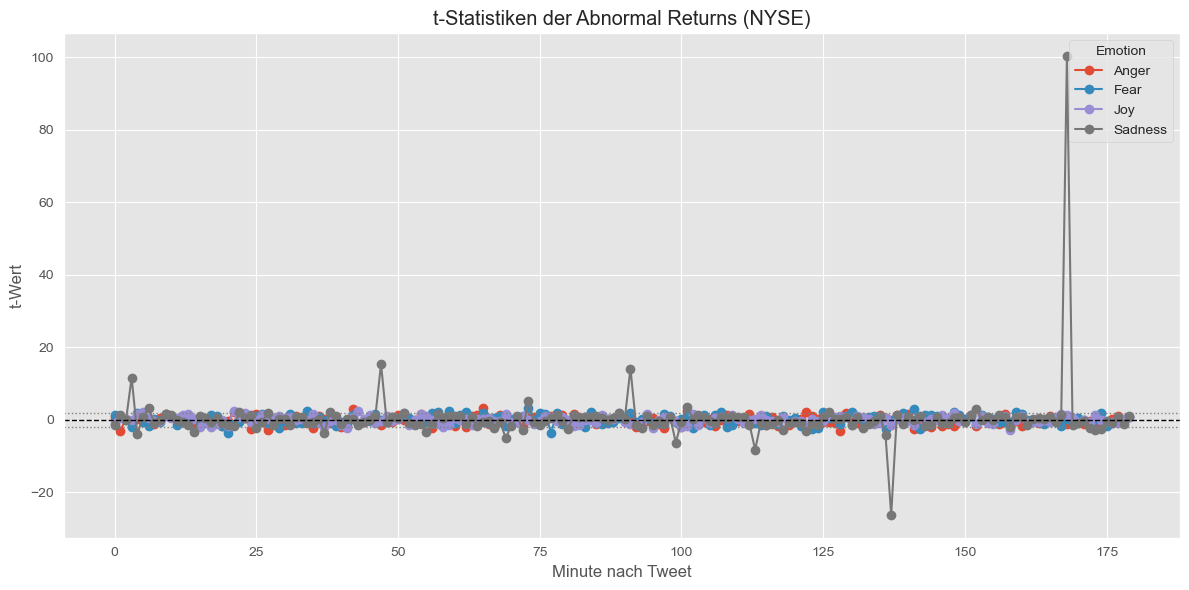

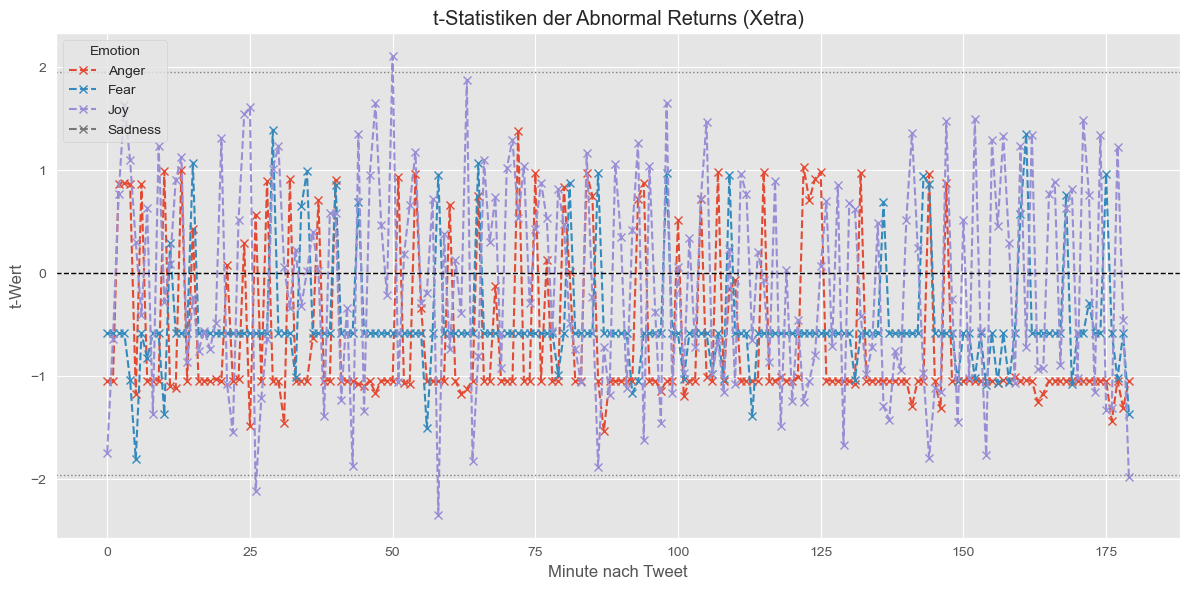

In [184]:
import matplotlib.pyplot as plt

# Emotionen aus den Spalten extrahieren (nehmen wir von NYSE)
t_stat_cols = [col for col in nyse_res.columns if col.endswith('_t_stat')]
emotions = [col.split('_')[0] for col in t_stat_cols]

# ---------- NYSE Plot ----------
plt.figure(figsize=(12, 6))
for emo in emotions:
    col = f"{emo}_abnormal_return_t_stat"
    if col in nyse_res.columns:
        plt.plot(nyse_res.index, nyse_res[col], label=emo.capitalize(), linestyle='-', marker='o')

plt.axhline(1.96, color='gray', linestyle='dotted', linewidth=1)
plt.axhline(-1.96, color='gray', linestyle='dotted', linewidth=1)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title("t-Statistiken der Abnormal Returns (NYSE)")
plt.xlabel("Minute nach Tweet")
plt.ylabel("t-Wert")
plt.legend(title="Emotion")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- XETRA Plot ----------
plt.figure(figsize=(12, 6))
for emo in emotions:
    col = f"{emo}_abnormal_return_t_stat"
    if col in xetra_res.columns:
        plt.plot(xetra_res.index, xetra_res[col], label=emo.capitalize(), linestyle='--', marker='x')

plt.axhline(1.96, color='gray', linestyle='dotted', linewidth=1)
plt.axhline(-1.96, color='gray', linestyle='dotted', linewidth=1)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title("t-Statistiken der Abnormal Returns (Xetra)")
plt.xlabel("Minute nach Tweet")
plt.ylabel("t-Wert")
plt.legend(title="Emotion")
plt.grid(True)
plt.tight_layout()
plt.show()


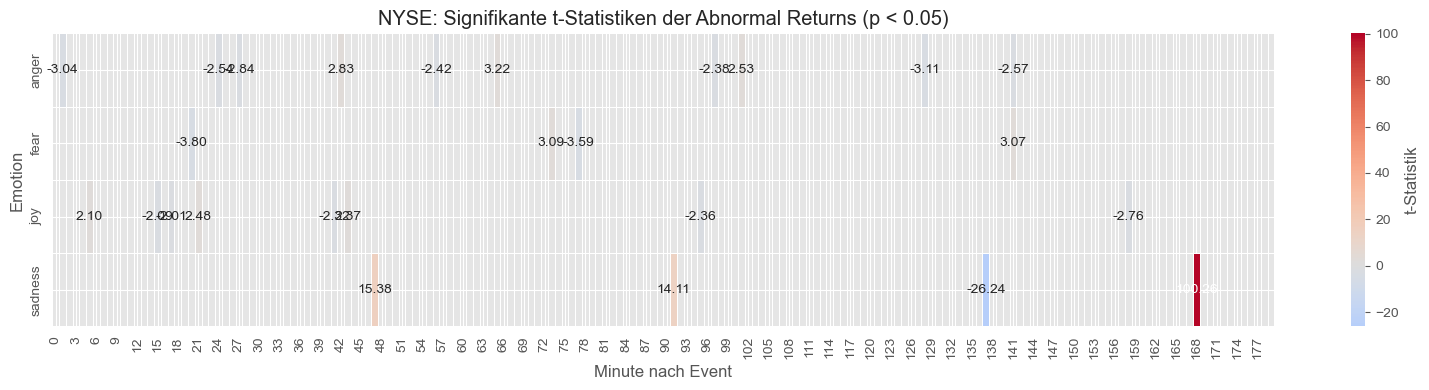

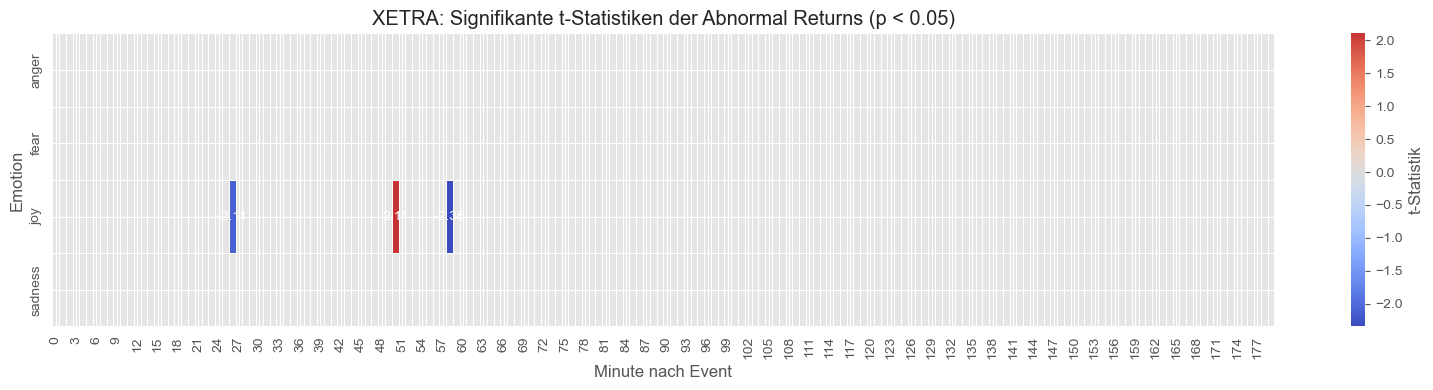

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_heatmaps(nyse_res, xetra_res, alpha=0.05):
    def prepare_heatmap_data(res_df):
        # Nur Spalten mit "_abnormal_return_t_stat"
        emotions = [col.split('_')[0] for col in res_df.columns if col.endswith('_abnormal_return_t_stat')]

        heatmap_data = pd.DataFrame({
            emo: res_df[f"{emo}_abnormal_return_t_stat"] for emo in emotions
        }).T

        pvalue_data = pd.DataFrame({
            emo: res_df[f"{emo}_abnormal_return_p_value"] for emo in emotions
        }).T

        # Nur signifikante Werte behalten
        heatmap_data = heatmap_data.where(pvalue_data < alpha)

        return heatmap_data, emotions

    # Daten vorbereiten
    nyse_heatmap, _ = prepare_heatmap_data(nyse_res)
    xetra_heatmap, _ = prepare_heatmap_data(xetra_res)

    # Plot für NYSE
    plt.figure(figsize=(16, 4))
    sns.heatmap(
        nyse_heatmap,
        cmap="coolwarm",
        center=0,
        annot=True,
        fmt=".2f",
        mask=nyse_heatmap.isnull(),
        cbar_kws={'label': 't-Statistik'},
        linewidths=.5
    )
    plt.xlabel("Minute nach Event")
    plt.ylabel("Emotion")
    plt.title("NYSE: Signifikante t-Statistiken der Abnormal Returns (p < 0.05)")
    plt.tight_layout()
    plt.show()

    # Plot für XETRA
    plt.figure(figsize=(16, 4))
    sns.heatmap(
        xetra_heatmap,
        cmap="coolwarm",
        center=0,
        annot=True,
        fmt=".2f",
        mask=xetra_heatmap.isnull(),
        cbar_kws={'label': 't-Statistik'},
        linewidths=.5
    )
    plt.xlabel("Minute nach Event")
    plt.ylabel("Emotion")
    plt.title("XETRA: Signifikante t-Statistiken der Abnormal Returns (p < 0.05)")
    plt.tight_layout()
    plt.show()

# Aufruf
plot_heatmaps(nyse_res, xetra_res)